In [107]:
import os
import sys
par_path = '/home/itamar/thesis/FacialLandmarkDetectionThesis'
os.chdir(par_path)
sys.path.append(par_path)
from main.top_level import TopLevel
from main.components.evaluator import Evaluator
import torch
from main.core.functions import inference
import numpy as np
import matplotlib.pyplot as plt
from utils.plot_utils import renorm_image
import torch.nn.functional as F
%matplotlib inline

task_id = 'af629c1deb324e1a9318ebffa787c482'

In [108]:
tl = TopLevel()
tl.init(task_id=task_id)
tl.setup_workspace()
lmd_eval = Evaluator(params=tl.params, logger_cml=tl.task.logger, task_id=tl.task.task_id)

Number of train images : 7862
Number of valid images : 1965
Loading TRANSPOSE Model
:: conv1.weight is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.weight is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.bias is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.running_mean is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.running_var is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn1.num_batches_tracked is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: conv2.weight is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn2.weight is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn2.bias is loaded from /home/itamar/thesis/MODELS/HRNET/hrnetv2_w18_imagenet_pretrained.pth
:: bn2.run

  1%|█                                                                          | 14/967 [00:00<00:07, 134.08it/s]

Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████████████| 967/967 [00:06<00:00, 146.23it/s]


In [109]:
res, dataset_eval = dict(), dict()
lmd_eval.model.eval()
lmd_eval.model.to(lmd_eval.device)

test_loader = lmd_eval.create_test_data_loader(dataset='300W')


In [110]:
np_detached = lambda x: x.cpu().detach() if not isinstance(x, np.ndarray) else x
item = next(iter(test_loader))

In [111]:
index = [0]
item['img'].shape

torch.Size([4, 3, 128, 128])

In [112]:
index = 0
img = item['img'][index]
input_, tpts = img.unsqueeze(0).cuda(), item['tpts'][index].unsqueeze(0).cuda()
img_viz = renorm_image(img)


In [144]:
model = lmd_eval.model
kwargs = {}

features = []
global_enc_atten_maps = []
reduce = []
forward = []

feature_hooks = [model.final_layer.register_forward_hook(lambda self, input, output1: features.append(output1))]
# x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)

reduce_hooks = [model.reduce.register_forward_hook(lambda self, input, output1: reduce.append(output1))]


atten_maps_hooks = [model.global_encoder.layers[i].self_attn.register_forward_hook(
    lambda self, input, output: global_enc_atten_maps.append(output[1])) for i in
    range(len(model.global_encoder.layers))]

forward_pre_hooks = [model.global_encoder.register_forward_hook(
    lambda self, input, output: forward.append(output)) for i in
    range(len(model.global_encoder.layers))]



with torch.no_grad():
    output, preds = inference(model=model, input_batch=input_, **{'model_name': tl.params.train.model})
    [h.remove() for h in feature_hooks]
    [h.remove() for h in atten_maps_hooks]
    [h.remove() for h in reduce_hooks]
    [h.remove() for h in query_hooks]
    [h.remove() for h in forward_pre_hooks]


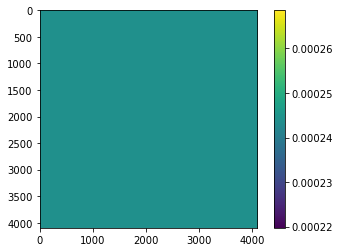

In [133]:
plt.imshow(global_enc_atten_maps[4][0].detach().cpu().numpy().astype(np.float32))
plt.colorbar()
# global_enc_atten_maps[0].shape

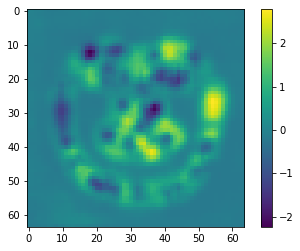

In [166]:
# for i in global_enc_atten_maps:
#     plt.figure()
#     plt.imshow(i[0].detach().cpu().numpy().astype(np.float32))
#     plt.colorbar()
# plt.imshow(forward_pre.detach().cpu().numpy().astype(np.float32))
aa = forward[2].reshape(64,64,256).sum(-1).detach().cpu().numpy().astype(np.float32)
plt.imshow(aa)
plt.colorbar()


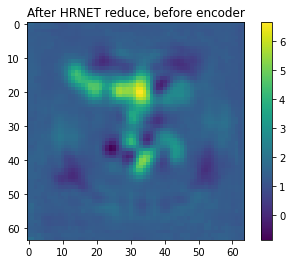

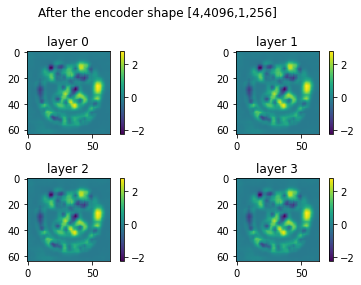

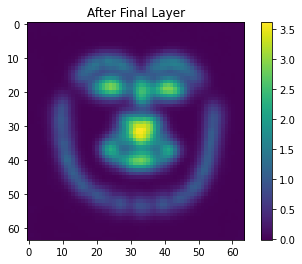

In [177]:

plt.figure()
aa = reduce[0].detach().cpu().numpy()[0].sum(0).astype(np.float32)
plt.imshow(aa)
plt.title('After HRNET reduce, before encoder')
plt.colorbar()

plt.figure()
plt.suptitle('After the encoder shape [4,4096,1,256]')
for layer in range(4):
    aa = forward[layer].reshape(64,64,256).sum(-1).detach().cpu().numpy().astype(np.float32)
    plt.subplot(2,2, layer+1, )
    plt.imshow(aa)
    plt.title(f'layer {layer}')
    plt.colorbar()
plt.tight_layout()

plt.figure()
aa = features[0].detach().cpu().numpy()[0].sum(0).astype(np.float32)
aa.max()
plt.imshow(aa)
plt.title('After Final Layer')
plt.colorbar()

# plt.figure()
# aa = reduce[0].detach().cpu().numpy()[0].sum(0).astype(np.float32)
# plt.imshow(aa)
# plt.title('After HRNET reduce')

# stage4[0].shape

In [ ]:
shape = features[0].shape[-2:]
enc_atten_maps_hwhw = []
for atten_map in global_enc_atten_maps:
    atten_map = atten_map.reshape(shape + shape)
    enc_atten_maps_hwhw.append(atten_map)

attn_layers_num = len(enc_atten_maps_hwhw)
down_rate = img_viz.shape[0] // shape[0]
# query locations are at the coordinate frame of original image
attn_map_pos = tpts[0] / down_rate

    

In [ ]:
plt.imshow(F.interpolate(features[0], tuple([64, 64]))[0].mean(0).detach().cpu().numpy())

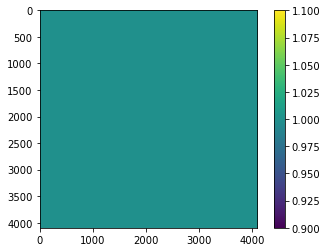

In [197]:
plt.imshow(global_enc_atten_maps[0][0].detach().cpu().numpy()/global_enc_atten_maps[0][0].detach().cpu().numpy().max())
plt.colorbar()

In [196]:
global_enc_atten_maps[3][0].max(), global_enc_atten_maps[3][0].min()

(tensor(0.0002, device='cuda:0'), tensor(0.0002, device='cuda:0'))

In [11]:
# random pos
x1 = img_viz.shape[1] * torch.rand(1)
y1 = img_viz.shape[0] * torch.rand(1)
x2 = img_viz.shape[1] * torch.rand(1)
y2 = img_viz.shape[0] * torch.rand(1)
random_pt_1 = [x1 / down_rate, y1 / down_rate]
random_pt_2 = [x2 / down_rate, y2 / down_rate]
attn_map_pos = attn_map_pos.tolist()
attn_map_pos.append(random_pt_1)
attn_map_pos.append(random_pt_2)


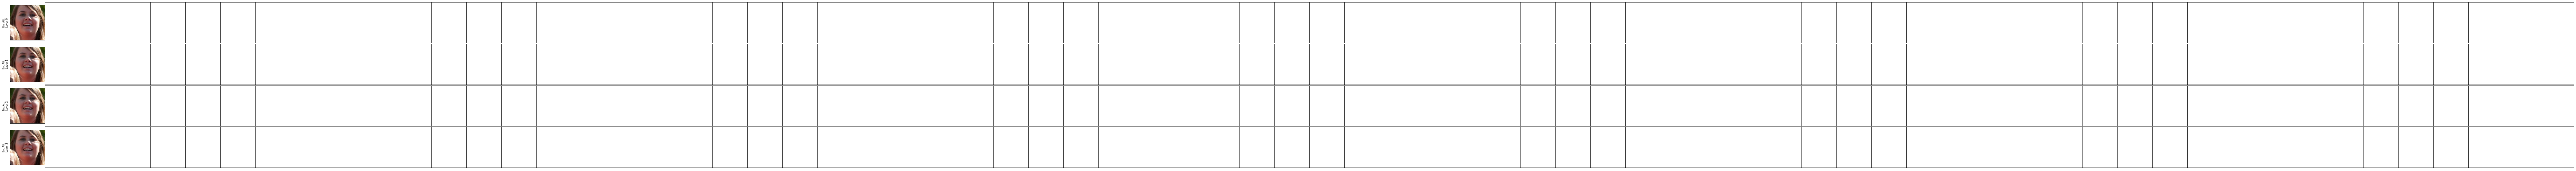

In [12]:
fig, axs = plt.subplots(attn_layers_num, len(attn_map_pos)+3, figsize=(120, 8), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.07, right=0.97, top=0.98, left=0.03, wspace=0.00008, hspace=0.02)
# For layer 1 only
for l in range(attn_layers_num[0]):
    axs[l][0].imshow(img_viz)
    axs[l][0].set_ylabel("Enc.Att.\nLayer {}".format(l), fontsize=8)
    axs[l][0].set_xticks([])
    axs[l][0].set_yticks([])


In [13]:
img_vis_new = img_viz.copy()
for idx, attn_map in enumerate(enc_atten_maps_hwhw):
    for p_id, p in enumerate(attn_map_pos):
        attention_map_for_this_point = F.interpolate(attn_map[None, None, int(p[1]), int(p[0]), :, :],scale_factor=down_rate,mode="bilinear",)[0][0]
        attention_map_for_this_point = (attention_map_for_this_point.squeeze().detach().cpu().numpy())
        x, y = p[0] * down_rate, p[1] * down_rate
        im = axs[idx][p_id + 1].imshow(attention_map_for_this_point, cmap="nipy_spectral", alpha=0.79)

        axs[idx][p_id+1].imshow(img_vis_new)
        
        axs[idx][p_id + 1].scatter(x=x, y=y, s=50, marker="*", c='red')
        # axs[idx][p_id + 1].set_xticks([])
        # axs[idx][p_id + 1].set_yticks([])

        if idx == attn_layers_num - 1:
            axs[idx][p_id + 1].set_xlabel(f"{p_id}", fontsize=25, )
            
cb = fig.colorbar(im, cax=cax, ax=axs, orientation="vertical", fraction=0.05, aspect=50)
plt.savefig("attention_map_{}_{}_{}.jpg".format('aaa', 'aaa', 'a'))

NameError: name 'cax' is not defined

In [65]:
all(attn_map[0] == 0.001)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [68]:
aa.max()

0.00024414062

In [28]:
np.vstack(aa).shape

(4096, 64, 64)

In [25]:
aa = enc_atten_maps_hwhw[0].detach().cpu().numpy()

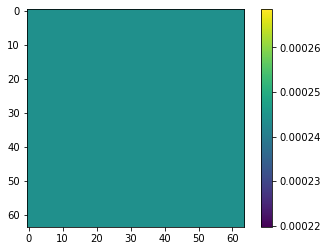

In [32]:
plt.imshow(aa.mean(axis=(0,3)))
plt.colorbar()

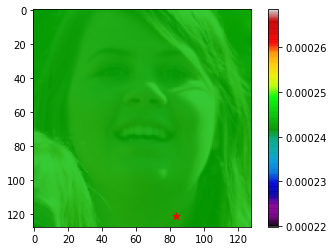

In [14]:
plt.figure()
plt.imshow(img_vis_new)
plt.imshow(attention_map_for_this_point, cmap="nipy_spectral", alpha=0.79)
plt.colorbar()
plt.scatter(x=x, y=y, s=50, marker="*", c='red')
plt.show()

In [15]:
x, y = p[0] * down_rate, p[1] * down_rate

In [ ]:
x, y

In [ ]:
for enc_atten_maps_hwhw_i in enc_atten_maps_hwhw:
    a = enc_atten_maps_hwhw_i.detach().cpu().numpy()
    plt.imshow(np.vstack(np.stack(np.vstack(a), -1)))
    plt.colorbar()
    plt.pause(0.01)

In [ ]:
(enc_atten_maps_hwhw_i == enc_atten_maps_hwhw_i[0][0]).detach().cpu().numpy().all()

In [ ]:
down_rate